# AlongTrack Data

In [16]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from oceanbench._src.geoprocessing.validation import validate_latlon, validate_time, decode_cf_time, validate_ssh
from oceanbench._src.preprocessing.alongtrack import alongtrack_ssh
from oceanbench._src.geoprocessing.subset import where_slice
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Challenge - 2020a - OSSE


> This data challenge looks at some simulated Altimetry data from simulations

In [17]:
!ls "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/"

2020a_SSH_mapping_NATL60_envisat.nc
2020a_SSH_mapping_NATL60_geosat2.nc
2020a_SSH_mapping_NATL60_jason1.nc
2020a_SSH_mapping_NATL60_karin_swot.nc
2020a_SSH_mapping_NATL60_nadir_swot.nc
2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc


In [36]:
files_nadir_dc20a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_jason1.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_geosat2.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc"
]

In [37]:
def preprocess_nadir_dc20a(da):
    
    # reorganized
    da = da.sortby("time").compute()
    
    # validate coordinates
    da = validate_latlon(da)
    da = validate_time(da)
    
    # validate variables
    da = da.rename({"ssh_model": "ssh"})
    da = validate_ssh(da)
    
    # # slice time period
    # da = da.sel(time=slice("2012-10-22", "2012-12-03"))
    
    # # slice region
    # da = where_slice(da, "lon", -64.975, -55.007)
    # da = where_slice(da, "lat", 33.025, 42.9917)
    

    
    # assign coordinates
    da = da.set_coords(["time", "lat", "lon"])
    
    return da[["ssh"]]

In [38]:
ds_nadir = xr.open_mfdataset(
    files_nadir_dc20a, 
    preprocess=preprocess_nadir_dc20a,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time").compute()

ds_nadir

<xarray.Dataset>
Dimensions:  (time: 205232)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:45:50.676369 ... 2013-09-30T...
    lon      (time) float64 -57.81 -57.83 -57.85 -57.87 ... -58.29 -58.31 -58.33
    lat      (time) float64 42.96 42.9 42.84 42.78 ... 42.82 42.88 42.94 43.0
Data variables:
    ssh      (time) float64 -0.0028 -0.0097 -0.0153 ... 0.244 0.2186 0.1897
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

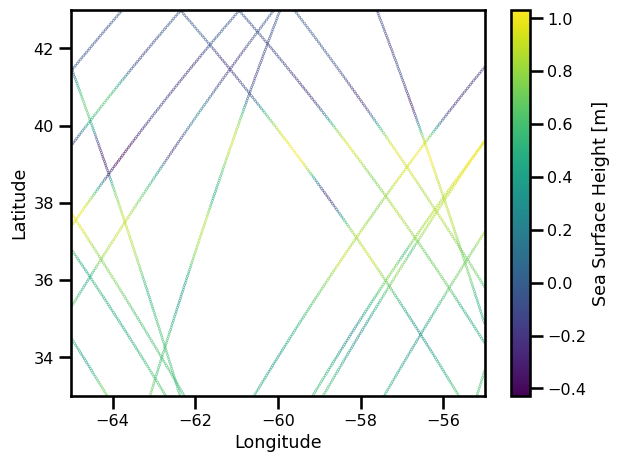

In [39]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.sel(time=slice("2012-10-22","2012-10-25"))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[ds_nadir.lon.min(), ds_nadir.lon.max()],
    ylim=[ds_nadir.lat.min(), ds_nadir.lat.max()],
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

## Data Challenge - 2021a - OSE

> This data challenge looks at some real altimetry data for sea surface height.

In [40]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train

dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc
dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc
dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc
dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc
dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc
dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc


In [41]:
files_nadir_dc21a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/train/dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc"
]


In [42]:
def preprocess_nadir_dc21a(da):
    
    # reorganized
    da = da.sortby("time").compute()
    
    # validate coordinates
    da = da.rename({"longitude": "lon", "latitude": "lat"})
    da = validate_latlon(da)
    da = validate_time(da)
    
    # # slice region
    # da = where_slice(da, "lon", -64.975, -55.007)
    # da = where_slice(da, "lat", 33.025, 42.9917)
    
    # # slice time period
    # da = da.sel(time=slice("2017-01-01", "2017-12-31"))
    
    # calculate SSH directly
    da = alongtrack_ssh(da)
    
    return da

In [44]:
ds_nadir = xr.open_mfdataset(
    files_nadir_dc21a, 
    preprocess=preprocess_nadir_dc21a,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time").compute()

ds_nadir

<xarray.Dataset>
Dimensions:         (time: 1793663)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T01:07:08.844252928 ... 2...
    lon             (time) float64 -50.5 -50.51 -50.52 ... -74.96 -74.97 -74.99
    lat             (time) float64 23.03 23.08 23.14 23.2 ... 25.21 25.27 25.33
Data variables:
    cycle           (time) float64 11.0 11.0 11.0 11.0 ... 193.0 193.0 193.0
    track           (time) float64 575.0 575.0 575.0 575.0 ... 83.0 83.0 83.0
    dac             (time) float32 -0.0565 -0.0569 -0.0571 ... -0.0842 -0.0847
    lwe             (time) float32 0.003 0.003 0.003 ... -0.005 -0.005 -0.005
    mdt             (time) float32 0.52 0.52 0.521 0.522 ... 0.621 0.622 0.623
    ocean_tide      (time) float64 0.0269 0.0288 0.0307 ... 0.302 0.3033 0.3046
    sla_filtered    (time) float32 0.101 0.103 0.105 0.109 ... 0.039 0.048 0.059
    sla_unfiltered  (time) float32 0.1 0.098 0.104 0.115 ... -0.01 0.069 0.046
    ssh             (time) float32 0.617 0.615 0.622 0.634 ... 0.616 0.696 0.674
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

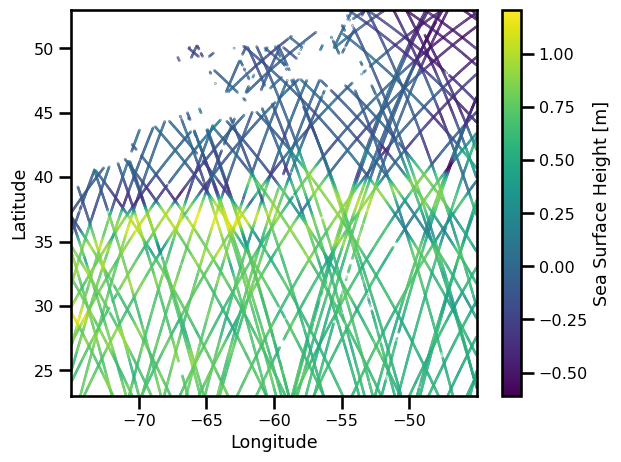

In [45]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.sel(time=slice("2017-01-10","2017-01-15"))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[ds_nadir.lon.min(), ds_nadir.lon.max()],
    ylim=[ds_nadir.lat.min(), ds_nadir.lat.max()],
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

## Data Challenge - 2023a - OSE

> This data challenge looks at the Western Mediterranean.

## Data Challenge - 2023b - OSE

> This data challenge looks at the Global dataset.

##

## Pangeo-Forge

See [this tutorial](https://gallery.pangeo.io/repos/pangeo-gallery/physical-oceanography/02_along_track.html)

**TODO**: Need to get the intake package working.

In [3]:
# from intake import open_catalog

# cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")
# list(cat)